# Exercise 7: Clustering

In this assignment you will experiment with k-means as an image compression algorithm.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. 
5. Your code must run without errors. Code that cannot run will also earn you the grade of 0.
6. Write your own code. Cheating will not be tolerated. 
8. Submission includes the this notebook only. Answers to qualitative questions should be written in markdown cells (with $\LaTeX$ support).

## Part 1: color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

You might need to install skimage using `conda install -c conda-forge scikit-image`.

In [15]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


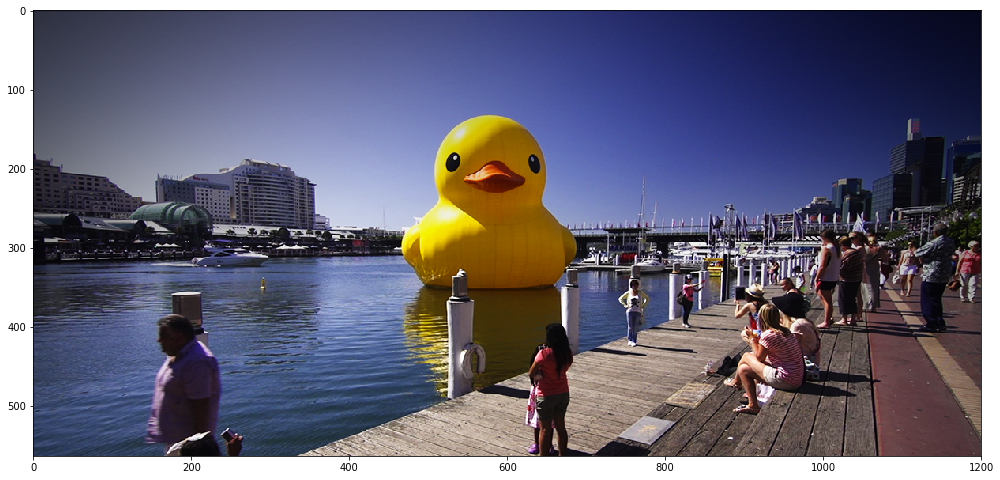

(564, 1200, 3)


In [16]:
# load the image and confirm skimage is imported properly.
image = io.imread('data/small_duck.jpg')
io.imshow(image)
io.show()
print(image.shape)

This single image has over 2 million values. Make sure your code is vectorized and efficient!

In [17]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
print(image.shape)

(676800, 3)


## Random centroids (15 points)

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.

Input: a single image of shape `(num_instances, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimentional array.
Output: Randomly chosen centroids of shape `(k,3)`.

In [18]:
def get_random_centroids(X, k):
    centroids = []
    ###########################################################################
    centroids = X[np.random.randint(X.shape[0], size=k), :]                                       #
    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return centroids

In [19]:
k = 7 
centroids = get_random_centroids(image, k)

In [20]:
print(centroids)

[[ 33  42 109]
 [182 178 167]
 [ 14  11  40]
 [ 51  59  80]
 [ 26  19  37]
 [ 12   8   7]
 [164 149 118]]


## Distance function (25 points)

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Implement the function `lp_distance` (=Minkoski distance).

Inputs: 
* a single image of shape `(num_instances, 3)` 
* the centroids `(k, 3)`
* the distance parameter p

output: array of shape `(k, num_instances)` thats holds the distances of all points in RGB space from all centroids

In [21]:
def lp_distance(X, centroids, p=2):
    distances = []
    ###########################################################################
    distances = np.power(np.sum(np.abs(X[:,None,:] - centroids[None,:,:]) ** p, axis=2), 1./p)
    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return distances.T

In [22]:
distances = lp_distance(image, centroids, 5)
print(distances.shape)
print(type(distances))
print(distances)

(7, 676800)
<class 'numpy.ndarray'>
[[3.06161415 3.04783288 2.95154632 ... 3.21409585 2.78982744 3.22155756]
 [3.39043641 3.01224531 3.02906112 ... 3.22341223 3.52984887 2.60517108]
 [3.10798991 2.49146188 3.44467575 ... 2.49146188 2.53166751 3.161822  ]
 ...
 [3.02429467 3.19128506 3.16978638 ... 3.13536803 2.99005778 3.13949624]
 [3.03143313 3.03615501 2.53651748 ... 3.53242165 3.4489267  3.161822  ]
 [3.15780952 3.16978638 2.96976713 ... 3.16978638 3.46572422 3.30108885]]


## Kmeans algorithm (40 points)

Calculate the locally optimal centroids as learned in class. At each iteration, assign every RGB point to the closest centroids and calculate new centroids by averaging the points that were assigned to every centroid. This function stops, 
when no improvement was made or once max_iter iterations passed.

A reasonable implementation runs on a Core i7 CPU in less than a minute with `k=16`.

In [23]:
def update_centroids(X, classes, k):
    array = np.array([X[classes == 0, :].mean(axis=0)])
    for i in range(1, k):
        array = np.concatenate((array, ([X[classes == i, :].mean(axis=0)])))
    return array

In [24]:
def kmeans(X, k, p, max_iter=100):
    """
    Inputs:
    - X: a single image of shape (num_features, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.
    Outpust:
    - The calculated centroids
    - The final assignment of all RGB points to the closest centroids
    """
    classes = []
    centroids = []
    
    ###########################################################################
    centroids = get_random_centroids(X, k)
    for i in range(max_iter):
        distances = lp_distance(X, centroids, p)
        classes = np.argmin(distances, axis=0)
        new_centroids = update_centroids(X, classes, k)
        
        if(new_centroids == centroids).all():
            break
        centroids = new_centroids

    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return centroids, classes

In [25]:
centroids, classes = kmeans(image, k=4, p=1, max_iter=100)

We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with some centroid. The following cell does that for you.

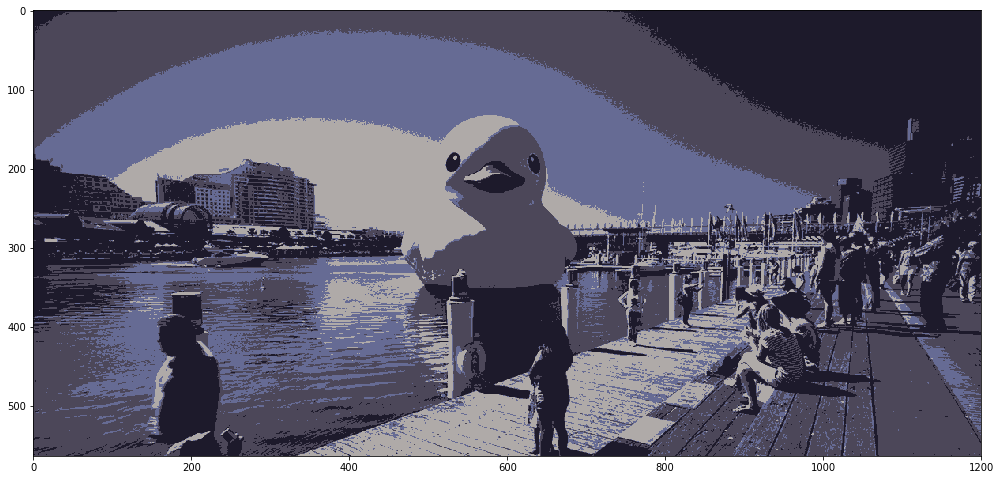

In [26]:
classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0],classes.shape[1],3),dtype=np.uint8 )
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
io.imshow(compressed_image)
io.show()

## Hyper parameter tuning (20 points)

Pick 5 values for `p` and compare the results. Include both qualtitative and quantitivie analysis such as graphs, images and additional visualizations and explanations as you see fit.

In [27]:
def ploty(centroids, classes):
    classes = classes.reshape(rows,cols) 
    compressed_image = np.zeros((classes.shape[0],classes.shape[1],3),dtype=np.uint8 )
    for i in range(classes.shape[0]):
        for j in range(classes.shape[1]):
                compressed_image[i,j,:] = centroids[classes[i,j],:]
    io.imshow(compressed_image)
    io.show()

P value: 1


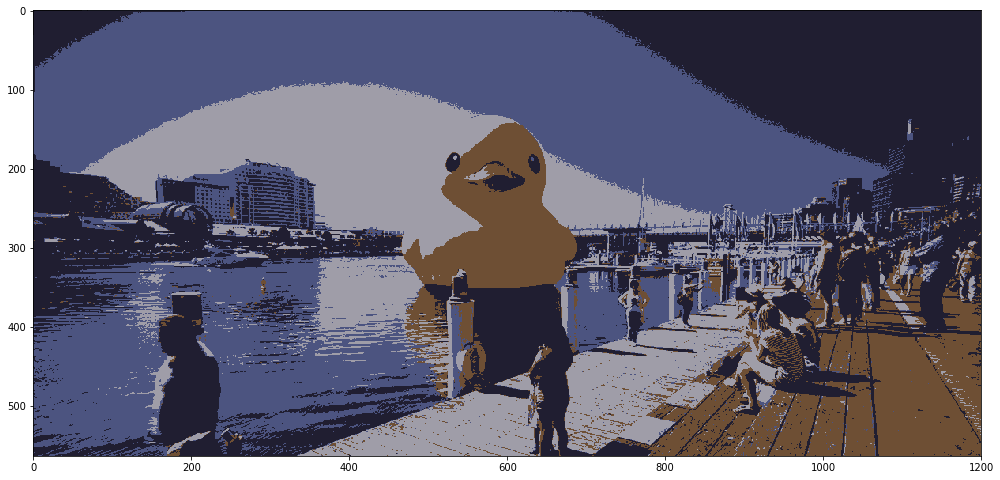

P value: 2


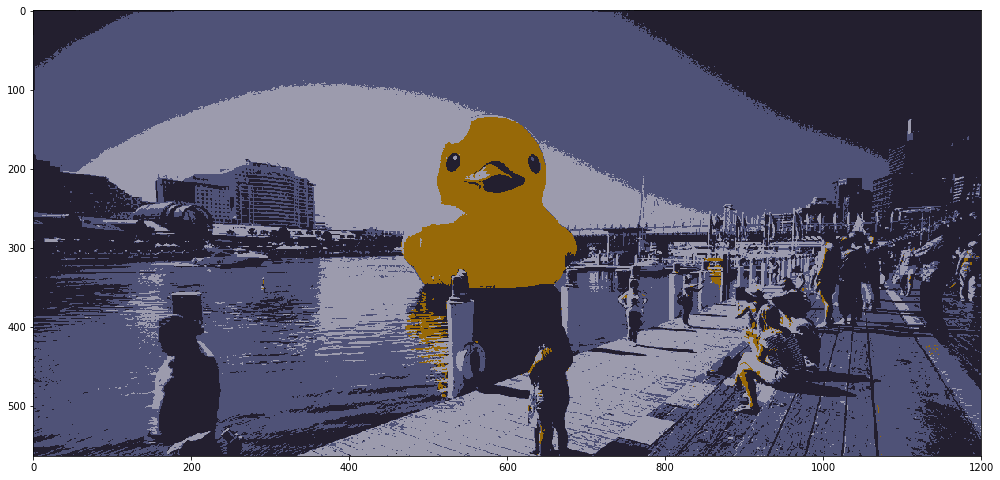

P value: 4


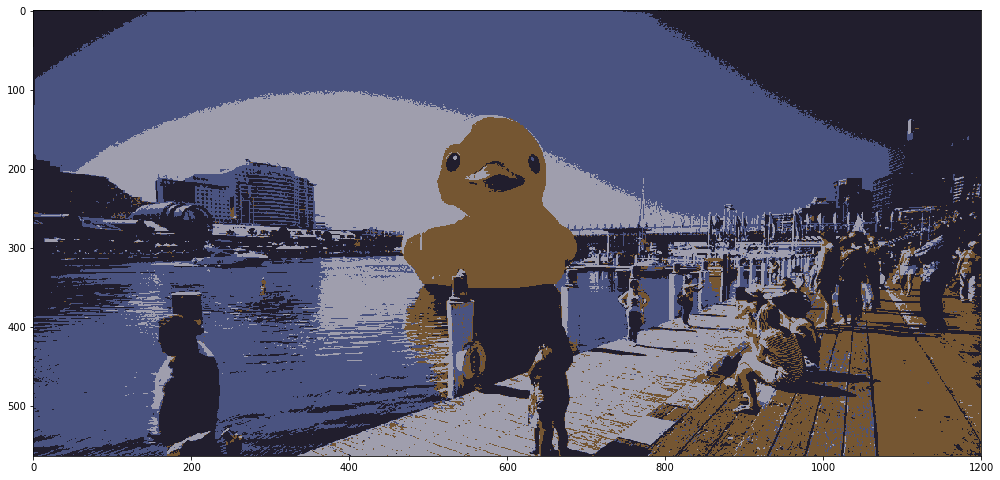

P value: 8


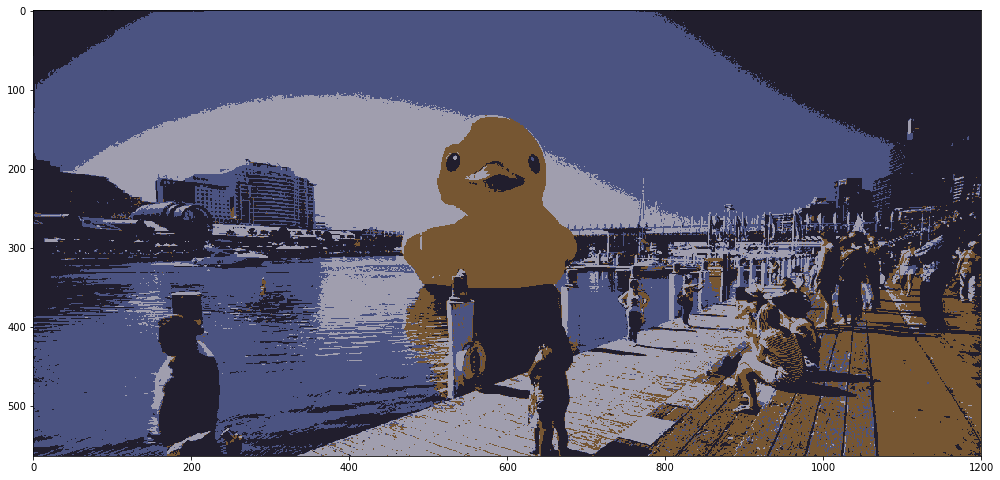

P value: 15


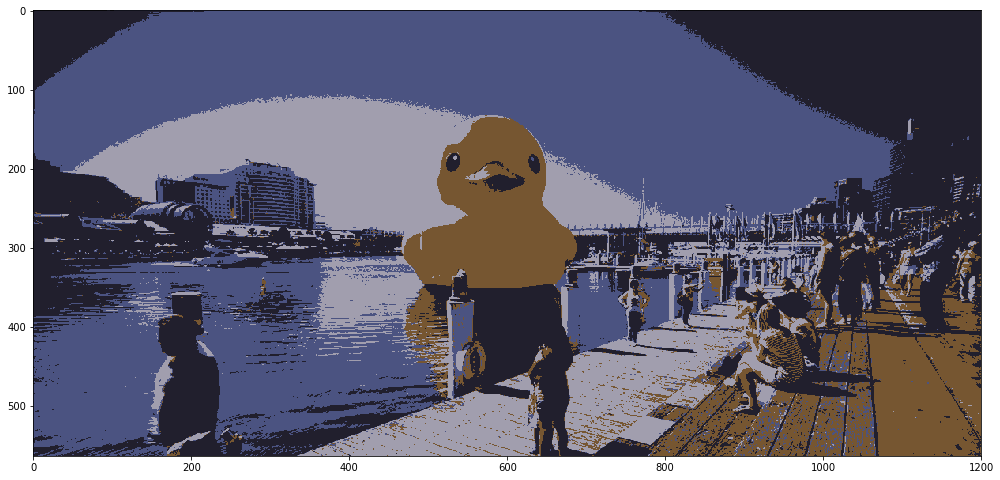

In [28]:
p_values = [1, 2, 4, 8, 15]
distances = []
class_tot = []
for p in p_values:
    print(f"P value: {p}")
    centroids, classes = kmeans(image, k=4, p=p, max_iter=100)
    c, amount = np.unique(classes, return_counts=True)
    class_tot.append(amount)
    dis = lp_distance(image, centroids, p)
    distances.append(np.sum(dis.min(axis=0)))
    ploty(centroids, classes)

# Elbow method gives us an idea on what a good k number of clusters would be based on the sum of squared distance between data points and their assigned clusters’ centroids

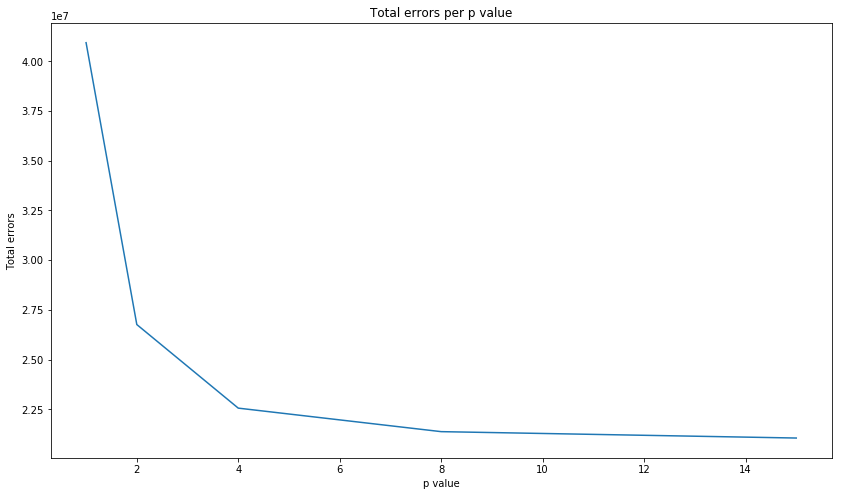

In [29]:
#Elbow method 

x = np.arange(len(distances))
plt.plot(p_values, distances)
plt.title("Total errors per p value")
plt.ylabel("Total errors") 
plt.xlabel("p value")
plt.show()

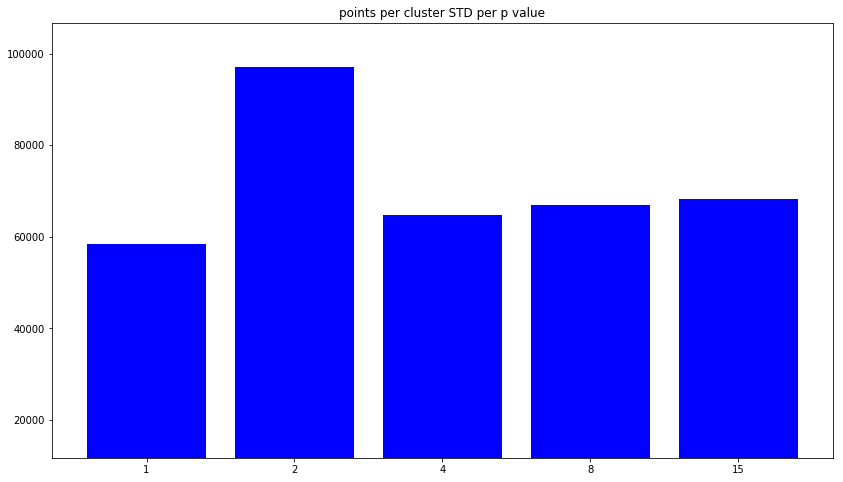

In [30]:
stds = [tot.std() for tot in class_tot]
height = stds
bars = ()
for p in p_values:
    bars = bars + (p,)
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color='blue')
plt.xticks(y_pos, bars)
ymin, ymax = min(stds), max(stds)
plt.ylim(ymin*0.2, 1.1 * ymax)
plt.title('points per cluster STD per p value')
plt.show()


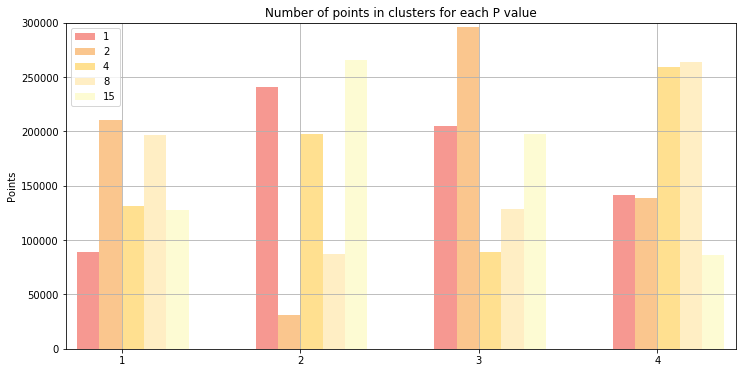

In [31]:
# Setting the positions and width for the bars
pos = range(4)
width = 0.125 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(12,6))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        class_tot[0], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label='0') 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p+width for p in pos], 
        class_tot[1],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label='1') 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        class_tot[2], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the third value in first_name
        label='2') 

plt.bar([p + width*3 for p in pos], 
        class_tot[3], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFDF8A', 
        # with label the third value in first_name
        label='3') 

plt.bar([p + width*4 for p in pos], 
        class_tot[4], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FCF9A9', 
        # with label the third value in first_name
        label='4') 

# Set the y axis label
ax.set_ylabel('Points')

# Set the chart's title
ax.set_title('Number of points in clusters for each P value')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(range(1,5))

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*5)
plt.ylim([0, 300000])

# Adding the legend and showing the plot
plt.legend([p_values[0], p_values[1], p_values[2], p_values[3], p_values[4]], loc='upper left')
plt.grid()
plt.show()